# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Modeling](#Modeling)
    - [4-Seam Fastball](#4-Seam-Fastball)
    - [Slider](#Slider)
    - [Changeup](#Changeup)
    - [Cutter](#Cutter)

# Imports

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, k_means
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
pd.set_option('max_columns', None)

data = pd.read_csv('../data/arsenal-spin.csv')
data.drop(columns = ['Unnamed: 0', 'player_id', 'pitches', 'n_pitches',
                     'diff_measured_inferred_minutes', 'diff_clock_hh', 
                     'diff_measured_inferred', 'hawkeye_measured', 'movement_inferred', 
                     'alan_active_spin_pct', 'diff2', 'diff_clock_mm'], inplace = True)
data = data.sort_values(by = ['last_name_x'], ascending = True)

# Binarize pitch types
data['pitch_type'] = data['pitch_type'].map({'FS': 5, 'FC': 4, 'CH': 3, 'SL': 2, 'FF': 1})

data = pd.get_dummies(data, columns = ['pitch_hand'])

# Index by Pitch Name
ff = data.loc[data['pitch_name_y'] == '4-Seam Fastball']
sl = data.loc[data['pitch_name_y'] == 'Slider']
ch = data.loc[data['pitch_name_y'] == 'Changeup']
fc = data.loc[data['pitch_name_y'] == 'Cutter']
fs = data.loc[data['pitch_name_y'] == 'Splitter']

print(data.shape)
data.head()

(869, 35)


,last_name_x,last_name_y,first_name_x,pitch_type,pitch_name_x,pitch_name_y,pitch_usage,release_speed,spin_rate,movement_inches,spin_eff%,active_spin,run_value_per_100,run_value,pa,ba,slg,woba,whiff_percent,k_percent,put_away,est_ba,est_slg,est_woba,hard_hit_percent,hawkeye_measured_clock_hh,hawkeye_measured_clock_mm,movement_inferred_clock_hh,movement_inferred_clock_mm,hawkeye_measured_clock_label,movement_inferred_clock_label,diff_clock_label,team_name_alt,pitch_hand_L,pitch_hand_R
0,Abreu,Abreu,Bryan,2,Slider,Slider,37.2,88.9,2526,6.2,32,0.324769,1.9,5,63,0.246,0.456,0.338,38.0,28.6,22.5,0.253,0.423,0.332,45.0,7,30,7,30,7:30,7:30,0H 00M,HOU,0,1
1,Abreu,Abreu,Bryan,1,4-Seamer,4-Seam Fastball,45.0,95.7,2216,18.6,93,0.925214,-0.1,0,66,0.273,0.418,0.379,23.9,12.1,11.4,0.274,0.428,0.367,34.0,1,0,1,0,1:00,1:00,0H 00M,HOU,0,1
2,Adams,Adams,Austin,2,Slider,Slider,87.1,86.9,2837,10.8,37,0.370953,-0.8,-7,217,0.145,0.208,0.288,35.3,33.2,28.7,0.158,0.256,0.307,23.7,8,15,9,0,8:15,9:00,-0H 45M,SD,0,1
3,Akin,Akin,Keegan,3,Changeup,Changeup,19.5,81.9,1936,17.4,95,0.953193,2.8,9,100,0.333,0.494,0.405,29.1,16.0,17.6,0.248,0.425,0.334,38.9,10,0,9,45,10:00,9:45,+0H 15M,BAL,1,0
4,Akin,Akin,Keegan,1,4-Seamer,4-Seam Fastball,57.2,92.0,2337,20.7,97,0.969171,-0.6,-6,231,0.250,0.451,0.331,20.0,22.1,14.2,0.253,0.487,0.353,43.9,10,45,11,0,10:45,11:00,-0H 15M,BAL,1,0


# Modeling

### 4-Seam Fastball

In [3]:
features_ff = ff.select_dtypes([np.number])

X_ff = features_ff

ss = StandardScaler()
X_ff_scaled = ss.fit_transform(X_ff)
X_ff_scaled[:,:] *= -1

pca = PCA().fit(X_ff_scaled)
principal_components_ff = pca.transform(X_ff_scaled)

model_ff = pd.DataFrame(data = principal_components_ff, columns = X_ff.columns)

print(model_ff.shape)
model_ff.head()

(389, 26)


,pitch_type,pitch_usage,release_speed,spin_rate,movement_inches,spin_eff%,active_spin,run_value_per_100,run_value,pa,ba,slg,woba,whiff_percent,k_percent,put_away,est_ba,est_slg,est_woba,hard_hit_percent,hawkeye_measured_clock_hh,hawkeye_measured_clock_mm,movement_inferred_clock_hh,movement_inferred_clock_mm,pitch_hand_L,pitch_hand_R
0,0.770524,-1.632626,1.626896,-1.718041,-0.207336,-0.340207,-2.015795,-0.545698,0.108957,0.430355,-0.307276,0.332791,0.926098,0.238488,-0.711348,0.561548,0.328158,-0.144825,-0.235978,0.090494,0.350282,0.213466,-0.102865,0.036042,5.551115e-17,-2.323204e-16
1,-0.193223,-0.195219,-3.182130,-0.616536,-0.737761,0.925881,0.276411,-1.870944,-0.425145,-0.202250,0.494141,-0.374908,0.226276,-0.235530,-0.795897,-0.028525,-0.312478,0.627591,0.583818,-0.157305,0.274197,-0.084404,0.160210,0.010564,-6.661338e-16,3.364301e-17
2,-0.616747,-2.424074,1.240893,0.004881,0.264172,-0.198628,-0.819263,-0.042656,-1.147386,-0.040314,-0.832084,-0.427737,0.621502,-0.010798,-0.048587,-0.054731,-0.225226,0.047081,-0.493705,0.404654,-0.100633,-0.096432,0.021942,0.032536,0.000000e+00,-6.134450e-17
3,-0.778479,-1.434431,1.961876,-0.433863,0.219429,-0.470459,0.519052,-0.447626,-0.657309,0.027598,-2.438154,-0.157842,-0.568530,-0.814060,-0.069487,0.062121,-0.322196,0.242351,-0.127170,0.229454,0.206325,-0.028523,-0.078022,0.028429,1.942890e-15,-4.413045e-17
4,0.855059,1.529596,-1.355197,-2.677133,0.379240,-0.452682,0.335240,0.731185,-1.807986,-1.123682,0.116703,0.395930,0.071450,0.048489,0.166678,-0.076393,-0.269039,-0.272868,-0.206430,0.184787,-0.153071,-0.504861,-0.092533,-0.026738,-1.110223e-15,4.833246e-17


In [4]:
km_ff = KMeans(n_clusters = 2, 
               random_state = 1)

km_ff.fit(model_ff)
label_ff = km_ff.fit_predict(model_ff)

print('Number of iterations:', km_ff.n_iter_)
print('Number of features:', km_ff.n_features_in_)
print('Number of clusters:', km_ff.n_clusters)
print('Inertia:', km_ff.inertia_)

print("Predicted clusters to points: ", label_ff[:10], '\n')
centroids_ff = km_ff.cluster_centers_
#print('Location of centroids:', '\n')
#print(centroids_ff)

Number of iterations: 7
Number of features: 26
Number of clusters: 2
Inertia: 7737.106538005017
Predicted clusters to points:  [1 0 0 0 1 0 0 1 1 1] 



### 4-Seam Cluster Labels

0: good

1: bad

In [5]:
X_ff['label'] = label_ff
model_ff['label'] = label_ff

#model_ff.groupby(by = 'label').mean().T
X_ff.groupby(by = 'label').mean().T

label,0,1
pitch_type,1.000000,1.000000
pitch_usage,49.418779,43.864205
release_speed,94.206103,93.226136
spin_rate,2303.000000,2237.284091
movement_inches,17.975117,17.341477
spin_eff%,89.845070,89.818182
active_spin,0.898609,0.898138
run_value_per_100,-0.699531,0.913636
run_value,-4.267606,3.875000
pa,148.938967,128.227273


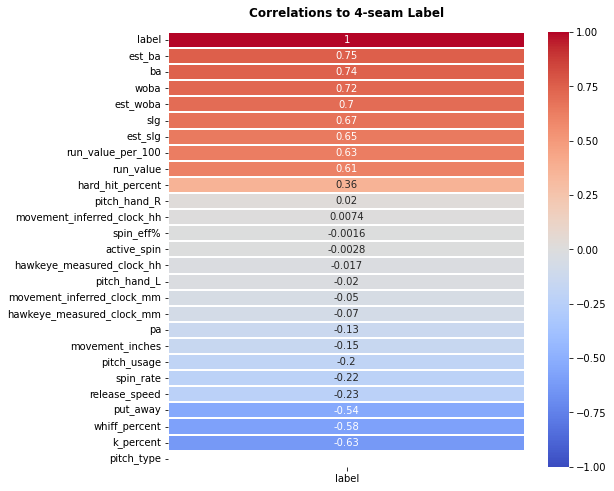

In [6]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_ff.corr()[['label']].sort_values(('label'), ascending = False), annot = True, 
            cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to 4-seam Label', fontweight = 'bold', pad = 15);

+: est_ba: 0.75, ba: 0.74, woba: 0.72,  est_woba: 0.70, slg: 0.67, est_slg: 0.65, run_value_per_100: 0.63,
run_value: 0.61, hard_hit_percent: 0.36

-: k_percent: -0.63, whiff_percent: -0.58, put_away: -0.54, release_speed: -0.23, spin_rate: -0.22

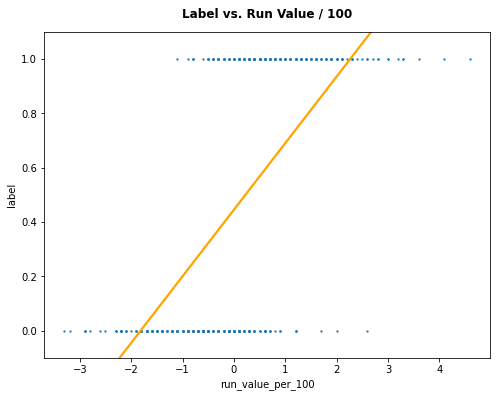

In [7]:
plt.figure(figsize = (8, 6))
sns.regplot(X_ff['run_value_per_100'], X_ff['label'], X_ff,
            ci = False, scatter_kws = {'s': 2},
            line_kws = {'color': 'orange'})
plt.ylim(-0.1, 1.1)
plt.title('Label vs. Run Value / 100', fontweight = 'bold', pad = 15);

In [8]:
X = X_ff[['run_value_per_100']]
#X = X_ff.drop(columns = ['label'])
y = X_ff['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

lr = LogisticRegression(random_state = 1)
lr.fit(X_train, y_train)

print('Predicted Labels:', lr.predict(X_test)[:10], '\n')
#print('Predicted Probabilites:', lr.predict_proba(X_test)[:10], '\n')
print('Train score:', round(lr.score(X_train, y_train), 2))
print('Test score:', round(lr.score(X_test, y_test), 2)) 
print('Cross val score', cross_val_score(lr, X_train, y_train))
#print('Coeff:', lr.coef_[:10])

Predicted Labels: [0 0 0 0 0 0 1 0 0 0] 

Train score: 0.81
Test score: 0.76
Cross val score [0.86440678 0.77586207 0.81034483 0.75862069 0.82758621]


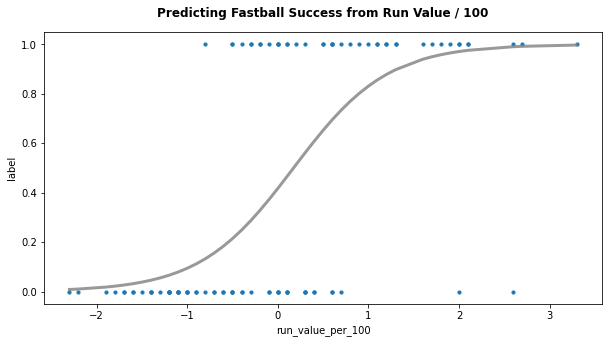

In [9]:
plt.figure(figsize = (10, 5))

plt.scatter(X_test, y_test, s = 10);
plt.plot(X_test.sort_values('run_value_per_100'),
         lr.predict_proba(X_test.sort_values('run_value_per_100'))[:,1],
         color = 'grey', alpha = 0.8, lw = 3)

plt.xlabel('run_value_per_100')
plt.ylabel('label')
plt.title('Predicting Fastball Success from Run Value / 100', fontweight = 'bold', pad = 15);

### Slider

In [10]:
features_sl = sl.select_dtypes([np.number])
X_sl = features_sl

#ss = StandardScaler()
X_sl_scaled = ss.fit_transform(X_sl)
X_sl_scaled[:,:] *= -1

pca = PCA().fit(X_sl_scaled)
principal_components_sl = pca.transform(X_sl_scaled)

model_sl = pd.DataFrame(data = principal_components_sl, columns = X_sl.columns)

print(model_sl.shape)
model_sl.head()

(256, 26)


,pitch_type,pitch_usage,release_speed,spin_rate,movement_inches,spin_eff%,active_spin,run_value_per_100,run_value,pa,ba,slg,woba,whiff_percent,k_percent,put_away,est_ba,est_slg,est_woba,hard_hit_percent,hawkeye_measured_clock_hh,hawkeye_measured_clock_mm,movement_inferred_clock_hh,movement_inferred_clock_mm,pitch_hand_L,pitch_hand_R
0,2.880401,-0.835802,-0.680670,1.648627,-1.032756,-0.369146,0.382079,-0.509145,-0.597735,0.904440,0.413538,0.831324,-0.247735,-0.316056,-0.283366,0.039194,-0.273100,0.230509,0.182194,-0.079808,0.304371,-0.178657,-0.118567,0.016105,0.000000e+00,-2.435256e-16
1,-2.344219,0.408986,-1.306453,2.435718,3.019983,-0.560231,2.213635,2.245345,0.552125,-0.011597,0.632679,0.083280,-0.603133,-1.083343,0.457995,-0.657036,-0.313920,0.265083,0.917791,0.499830,0.043928,0.037144,-0.066778,-0.000963,7.771561e-16,-5.457866e-17
2,7.382030,-0.632466,3.366989,-0.430576,-0.268126,-0.614957,0.541805,-0.319811,0.116801,-0.370106,0.170642,1.375851,0.262915,0.180391,-0.068665,0.206249,0.155823,0.287191,-0.078267,0.143664,0.036774,-0.246791,-0.094141,-0.004494,-2.220446e-16,-1.109112e-16
3,-1.447973,-1.304864,-2.015132,0.253503,0.741940,1.596048,-0.273967,-0.169709,-0.635396,1.031868,0.902861,0.004826,0.334123,0.367482,0.345083,-0.342312,-0.271856,-0.139011,-0.164871,-0.031171,0.106747,0.044899,-0.047390,-0.006494,1.665335e-16,-1.991432e-17
4,-0.243198,-2.643763,-2.721474,0.314356,0.333470,-1.070927,-1.843172,0.122004,-0.246327,-1.398313,0.038718,0.459600,-0.343591,0.022993,0.756373,-0.238727,0.114282,0.172107,0.475244,-0.501130,-0.064718,0.022558,0.067502,0.014784,-5.551115e-16,-3.590272e-18


In [11]:
km_sl = KMeans(n_clusters = 2, 
               random_state = 1)

km_sl.fit(model_sl)
label_sl = km_sl.fit_predict(model_sl)

print('Number of iterations:', km_sl.n_iter_)
print('Number of features:', km_sl.n_features_in_)
print('Number of clusters:', km_sl.n_clusters)
print('Inertia:', km_sl.inertia_)

print("Predicted clusters to points: ", label_sl[:10], '\n')
centroids_sl = km_sl.cluster_centers_
#print('Location of centroids:', '\n')
#print(centroids_sl)

Number of iterations: 10
Number of features: 26
Number of clusters: 2
Inertia: 5018.941862505129
Predicted clusters to points:  [0 1 0 1 1 0 0 1 0 0] 



# Slider Cluster Labels

0: bad

1: good

In [12]:
X_sl['label'] = label_sl
model_sl['label'] = label_sl

#model_sl.groupby(by = 'label').mean().T
X_sl.groupby(by = 'label').mean().T

label,0,1
pitch_type,2.000000,2.000000
pitch_usage,28.982031,35.265625
release_speed,84.442969,84.846094
spin_rate,2370.906250,2476.359375
movement_inches,7.346875,9.587500
spin_eff%,34.218750,38.898438
active_spin,0.342528,0.389190
run_value_per_100,0.589063,-1.462500
run_value,1.757812,-5.851562
pa,104.945312,109.742188


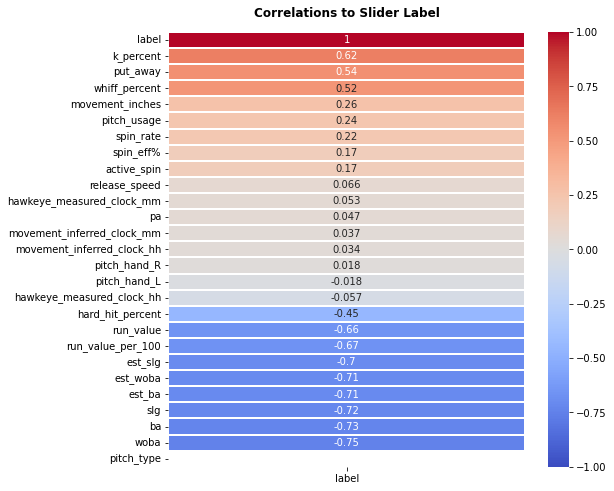

In [13]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_sl.corr()[['label']].sort_values(('label'), ascending = False), annot = True, 
            cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Slider Label', fontweight = 'bold', pad = 15);

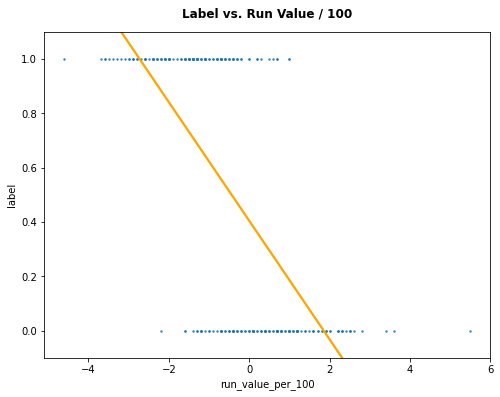

In [14]:
plt.figure(figsize = (8, 6))
sns.regplot(X_sl['run_value_per_100'], X_sl['label'], X_sl,
            ci = False, scatter_kws = {'s': 2},
            line_kws = {'color': 'orange'})
plt.ylim(-0.1, 1.1)
plt.title('Label vs. Run Value / 100', fontweight = 'bold', pad = 15);

In [15]:
X = X_sl[['run_value_per_100']]
#X = X_sl.drop(columns = ['label'])
y = X_sl['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

lr = LogisticRegression(random_state = 1)
lr.fit(X_train, y_train)

print('Predicted Labels:', lr.predict(X_test)[:10], '\n')
#print('Predicted Probabilites:', lr.predict_proba(X_test)[:10], '\n')
print('Train score:', round(lr.score(X_train, y_train), 2))
print('Test score:', round(lr.score(X_test, y_test), 2)) 
print('Cross val score', cross_val_score(lr, X_train, y_train))
#print('Coeff:', lr.coef_[:10])

Predicted Labels: [0 1 0 0 0 1 0 0 0 0] 

Train score: 0.82
Test score: 0.84
Cross val score [0.79487179 0.87179487 0.86842105 0.78947368 0.76315789]


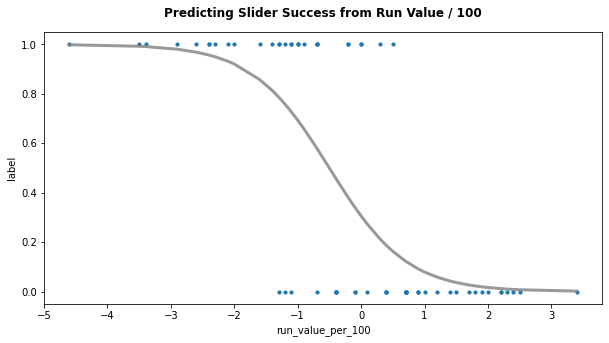

In [16]:
plt.figure(figsize = (10, 5))

plt.scatter(X_test, y_test, s = 10);
plt.plot(X_test.sort_values('run_value_per_100'),
         lr.predict_proba(X_test.sort_values('run_value_per_100'))[:,1],
         color = 'grey', alpha = 0.8, lw = 3)

plt.xlabel('run_value_per_100')
plt.ylabel('label')
plt.title('Predicting Slider Success from Run Value / 100', fontweight = 'bold', pad = 15);

### Changeup

In [17]:
features_ch = ch.select_dtypes([np.number])
X_ch = features_ch

#ss = StandardScaler()
X_ch_scaled = ss.fit_transform(X_ch)
X_ch_scaled[:,:] *= -1

pca = PCA().fit(X_ch_scaled)
principal_components_ch = pca.transform(X_ch_scaled)

model_ch = pd.DataFrame(data = principal_components_ch, columns = X_ch.columns)

print(model_ch.shape)
model_ch.head()

(124, 26)


,pitch_type,pitch_usage,release_speed,spin_rate,movement_inches,spin_eff%,active_spin,run_value_per_100,run_value,pa,ba,slg,woba,whiff_percent,k_percent,put_away,est_ba,est_slg,est_woba,hard_hit_percent,hawkeye_measured_clock_hh,hawkeye_measured_clock_mm,movement_inferred_clock_hh,movement_inferred_clock_mm,pitch_hand_L,pitch_hand_R
0,3.838901,-1.789586,0.079293,2.025160,-0.139043,0.274742,-0.433430,1.154736,-0.947173,-1.289925,-0.235889,0.043182,0.774673,0.057781,-0.226849,-0.243623,-0.562172,-0.244175,-0.013866,0.527057,-0.077529,-0.064092,-0.083266,-0.019204,-1.110223e-16,-5.943272e-16
1,-1.528015,1.601608,-0.128303,0.158319,-0.429225,0.675530,-1.401995,-2.742256,0.623417,-0.598504,-2.102805,-0.156462,-0.396004,0.114844,0.227643,0.113219,-0.176500,0.039998,-0.021893,-0.043547,0.092132,0.002026,-0.033851,0.008364,7.771561e-16,8.936635e-17
2,1.916752,-1.960125,1.018966,-0.191602,1.377595,0.768011,-0.722759,-0.516189,-0.659827,-0.357621,0.203893,0.254846,1.069064,-0.230894,0.542792,0.350080,0.149817,-0.213281,-0.246523,-0.015358,0.062471,0.056184,0.049711,-0.003628,-4.440892e-16,-5.021989e-17
3,3.343230,-2.155201,-0.771797,-0.019788,0.571534,-0.819468,0.845386,0.462860,0.421524,0.497682,0.446061,-0.187120,-0.200507,-0.253878,0.285215,-0.003665,-0.000449,-0.212573,0.083705,0.077857,0.010874,-0.208913,-0.013125,0.005504,-5.551115e-16,-6.257456e-17
4,2.106054,-2.730200,-0.457831,0.558362,-1.036539,0.677609,0.244370,0.699622,0.280818,-0.217135,-0.034793,-0.101821,0.127393,0.436193,-0.675755,-0.051652,0.449826,0.396365,0.055777,-0.062790,0.231000,-0.022582,-0.034040,-0.012815,-4.440892e-16,-6.912156e-18


In [18]:
km_ch = KMeans(n_clusters = 2, 
               random_state = 1)

km_ch.fit(model_ch)
label_ch = km_ch.fit_predict(model_ch)

print('Number of iterations:', km_ch.n_iter_)
print('Number of features:', km_ch.n_features_in_)
print('Number of clusters:', km_ch.n_clusters)
print('Inertia:', km_ch.inertia_)

print("Predicted clusters to points: ", label_ch[:10], '\n')
centroids_ch = km_ch.cluster_centers_
#print('Location of centroids:', '\n')
#print(centroids_ch)

Number of iterations: 10
Number of features: 26
Number of clusters: 2
Inertia: 2486.3269202727724
Predicted clusters to points:  [0 1 0 0 0 1 1 1 0 0] 



# Changeup Cluster Labels

0: bad

1: good

In [19]:
X_ch['label'] = label_ch
model_ch['label'] = label_ch

#model_ch.groupby(by = 'label').mean().T
X_ch.groupby(by = 'label').mean().T

label,0,1
pitch_type,3.000000,3.000000
pitch_usage,21.281818,27.474138
release_speed,84.296970,85.062069
spin_rate,1715.409091,1796.206897
movement_inches,15.940909,16.577586
spin_eff%,89.863636,90.482759
active_spin,0.899329,0.906075
run_value_per_100,0.863636,-1.043103
run_value,3.136364,-4.344828
pa,109.166667,121.982759


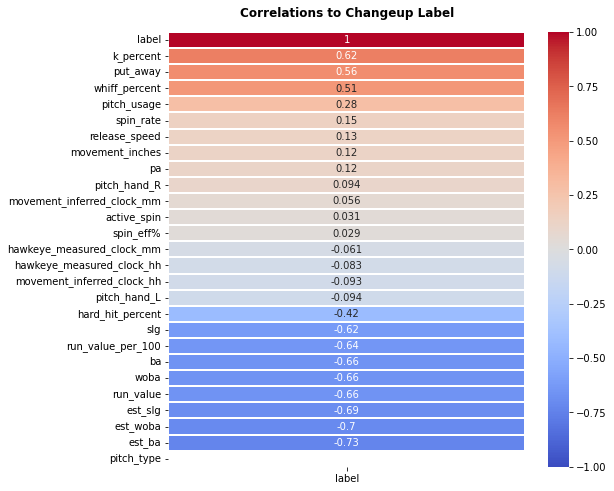

In [20]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_ch.corr()[['label']].sort_values(('label'), ascending = False), annot = True, 
            cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Changeup Label', fontweight = 'bold', pad = 15);

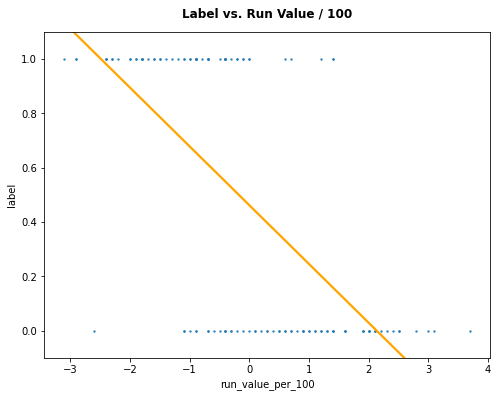

In [21]:
plt.figure(figsize = (8, 6))
sns.regplot(X_ch['run_value_per_100'], X_ch['label'], X_ch,
            ci = False, scatter_kws = {'s': 2},
            line_kws = {'color': 'orange'})
plt.ylim(-0.1, 1.1)
plt.title('Label vs. Run Value / 100', fontweight = 'bold', pad = 15);

In [22]:
X = X_ch[['run_value_per_100']]
#X = X_ch.drop(columns = ['label'])
y = X_ch['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

lr = LogisticRegression(random_state = 1)
lr.fit(X_train, y_train)

print('Predicted Labels:', lr.predict(X_test)[:10], '\n')
#print('Predicted Probabilites:', lr.predict_proba(X_test)[:10], '\n')
print('Train score:', round(lr.score(X_train, y_train), 2))
print('Test score:', round(lr.score(X_test, y_test), 2)) 
print('Cross val score', cross_val_score(lr, X_train, y_train))
#print('Coeff:', lr.coef_[:10])

Predicted Labels: [0 1 1 0 1 0 0 0 1 0] 

Train score: 0.78
Test score: 0.74
Cross val score [0.84210526 0.78947368 0.63157895 0.83333333 0.77777778]


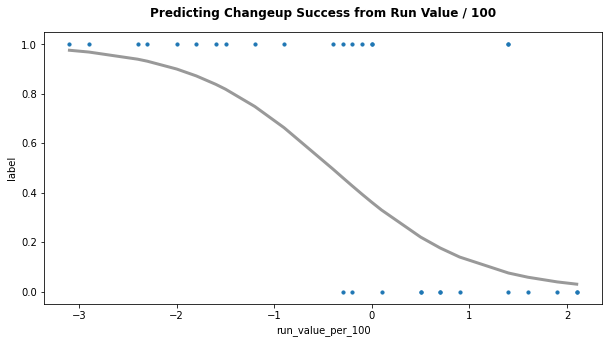

In [23]:
plt.figure(figsize = (10, 5))

plt.scatter(X_test, y_test, s = 10);
plt.plot(X_test.sort_values('run_value_per_100'),
         lr.predict_proba(X_test.sort_values('run_value_per_100'))[:,1],
         color = 'grey', alpha = 0.8, lw = 3)

plt.xlabel('run_value_per_100')
plt.ylabel('label')
plt.title('Predicting Changeup Success from Run Value / 100', fontweight = 'bold', pad = 15);

### Cutter

In [24]:
features_fc = fc.select_dtypes([np.number])

X_fc = features_fc

#ss = StandardScaler()
X_fc_scaled = ss.fit_transform(X_fc)
X_fc_scaled[:,:] *= -1

pca = PCA().fit(X_fc_scaled)
principal_components_fc = pca.transform(X_fc_scaled)

model_fc = pd.DataFrame(data = principal_components_fc, columns = X_fc.columns)

print(model_fc.shape)
model_fc.head()

(80, 26)


,pitch_type,pitch_usage,release_speed,spin_rate,movement_inches,spin_eff%,active_spin,run_value_per_100,run_value,pa,ba,slg,woba,whiff_percent,k_percent,put_away,est_ba,est_slg,est_woba,hard_hit_percent,hawkeye_measured_clock_hh,hawkeye_measured_clock_mm,movement_inferred_clock_hh,movement_inferred_clock_mm,pitch_hand_L,pitch_hand_R
0,0.355800,-1.451022,2.598807,-1.611514,-0.747029,-0.313442,0.386414,1.157222,-1.822465,0.193576,0.905560,-0.922456,0.537167,-0.818594,-0.911853,0.207423,0.320115,0.288511,0.021063,0.234703,-0.265253,-0.163395,-0.036894,0.010828,-5.551115e-16,-5.082740e-16
1,-3.614199,-2.490453,1.358594,-0.969626,-0.185298,1.393185,1.156961,0.893962,-0.400830,1.139808,-1.015386,-1.029599,0.979118,-0.357200,-0.529504,-0.286509,0.259300,-0.075256,0.124013,-0.293433,-0.182831,-0.009047,-0.027553,0.001446,0.000000e+00,-2.046974e-16
2,0.811326,-0.405970,1.871501,-1.058796,-0.502283,-1.400143,0.399528,-0.165389,0.478938,-1.543067,0.695227,0.478430,-0.753432,0.558206,0.082733,-0.713214,0.146997,0.284952,0.000510,-0.047346,0.172579,-0.024909,0.077016,0.018431,9.992007e-16,0.000000e+00
3,-1.615508,-0.623920,-3.190345,-0.132340,-0.494991,-1.071552,-0.561299,-0.907667,-1.894704,0.033800,0.099065,0.094085,-0.174839,0.311842,0.501867,-0.016067,0.682291,0.460857,-0.138177,0.029318,0.413878,-0.014813,-0.219756,0.006944,-3.330669e-16,1.734723e-17
4,0.097073,-0.454575,-2.243936,-0.955025,1.461860,-0.821940,-0.421484,0.223109,0.088309,1.501040,-0.020861,-0.044204,0.265533,0.012898,0.294211,-0.065937,0.295150,0.037524,0.074847,0.337476,0.333293,-0.299321,-0.010528,0.014890,-3.330669e-16,-1.387779e-17


In [25]:
km_fc = KMeans(n_clusters = 2, 
               random_state = 1)

km_fc.fit(model_fc)
label_fc = km_fc.fit_predict(model_fc)

print('Number of iterations:', km_fc.n_iter_)
print('Number of features:', km_fc.n_features_in_)
print('Number of clusters:', km_fc.n_clusters)
print('Inertia:', km_fc.inertia_)

print("Predicted clusters to points: ", label_fc[:10], '\n')
centroids_fc = km_fc.cluster_centers_
#print('Location of centroids:', '\n')
#print(centroids_fc)

Number of iterations: 8
Number of features: 26
Number of clusters: 2
Inertia: 1565.5628719756817
Predicted clusters to points:  [1 0 1 0 0 0 1 1 0 1] 



# Cutter Cluster Labels

0: bad

1: good

In [26]:
X_fc['label'] = label_fc
model_fc['label'] = label_fc

#model_fc.groupby(by = 'label').mean().T
X_fc.groupby(by = 'label').mean().T

label,0,1
pitch_type,4.000000,4.000000
pitch_usage,28.228571,35.726316
release_speed,87.980952,88.915789
spin_rate,2291.952381,2451.263158
movement_inches,8.916667,8.081579
spin_eff%,51.523810,42.500000
active_spin,0.515399,0.425604
run_value_per_100,0.783333,-1.126316
run_value,3.000000,-5.263158
pa,123.476190,117.105263


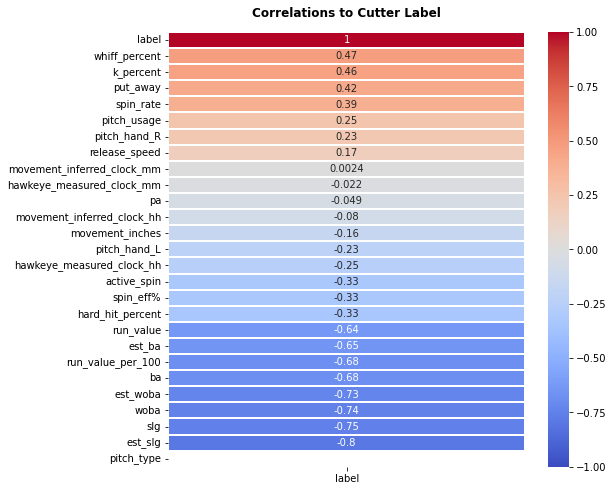

In [27]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_fc.corr()[['label']].sort_values(('label'), ascending = False), annot = True, 
            cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Cutter Label', fontweight = 'bold', pad = 15);

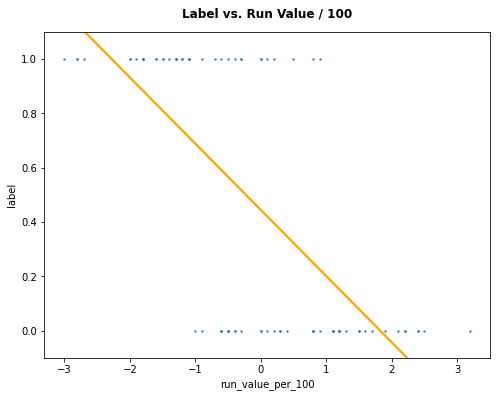

In [28]:
plt.figure(figsize = (8, 6))
sns.regplot(X_fc['run_value_per_100'], X_fc['label'], X_fc,
            ci = False, scatter_kws = {'s': 2},
            line_kws = {'color': 'orange'})
plt.ylim(-0.1, 1.1)
plt.title('Label vs. Run Value / 100', fontweight = 'bold', pad = 15);

In [29]:
X = X_fc[['run_value_per_100']]
#X = X_fc.drop(columns = ['label'])
y = X_fc['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

lr = LogisticRegression(random_state = 1)
lr.fit(X_train, y_train)

print('Predicted Labels:', lr.predict(X_test)[:10], '\n')
#print('Predicted Probabilites:', lr.predict_proba(X_test)[:10], '\n')
print('Train score:', round(lr.score(X_train, y_train), 2))
print('Test score:', round(lr.score(X_test, y_test), 2)) 
print('Cross val score', cross_val_score(lr, X_train, y_train))
#print('Coeff:', lr.coef_[:10])

Predicted Labels: [1 1 1 1 1 1 1 1 1 0] 

Train score: 0.8
Test score: 0.7
Cross val score [0.66666667 0.91666667 0.83333333 0.91666667 0.66666667]


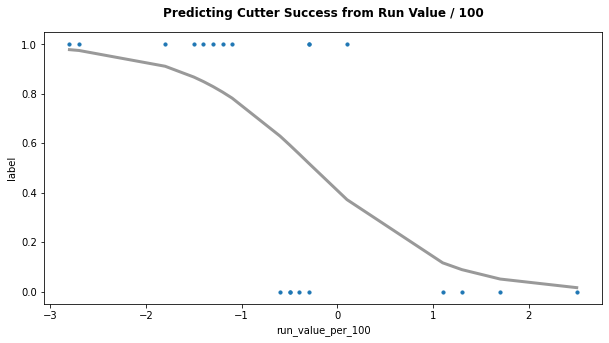

In [30]:
plt.figure(figsize = (10, 5))

plt.scatter(X_test, y_test, s = 10);
plt.plot(X_test.sort_values('run_value_per_100'),
         lr.predict_proba(X_test.sort_values('run_value_per_100'))[:,1],
         color = 'grey', alpha = 0.8, lw = 3)

plt.xlabel('run_value_per_100')
plt.ylabel('label')
plt.title('Predicting Cutter Success from Run Value / 100', fontweight = 'bold', pad = 15);